# Описание данных

Данные - специально подготовленная выборка из полного набора, описанного здесь: https://mengtingwan.github.io/data/goodreads#datasets с дополнениями из https://www.kaggle.com/datasets/austinreese/goodreads-books:
- books: перечень книг (~44 тыс.) из списка https://www.goodreads.com/list/show/1.Best_Books_Ever (совпадение по book id),
- interactions: взаимодействие пользователей с книгами

Основной массив данных был собран в конце 2017.

# Инициализация

In [15]:
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

Создаём логгер, который удобен для использования в ноутбуке.

# Load Data

Загружаем данные как они есть, начинаем на них смотреть: какие в них есть сущности, атрибуты, распределения.

In [3]:
books = pd.read_parquet("books.parquet")

In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43312 entries, 3 to 2360448
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   book_id               43312 non-null  int64  
 1   author                43312 non-null  object 
 2   title                 43312 non-null  object 
 3   description           43312 non-null  object 
 4   genre_and_votes       43312 non-null  object 
 5   num_pages             37001 non-null  Int64  
 6   average_rating        43312 non-null  float64
 7   ratings_count         43312 non-null  Int64  
 8   text_reviews_count    43312 non-null  int64  
 9   publisher             43312 non-null  object 
 10  publication_year      35891 non-null  Int64  
 11  country_code          43312 non-null  object 
 12  language_code         43312 non-null  object 
 13  format                43312 non-null  object 
 14  is_ebook              43312 non-null  bool   
 15  isbn                  

Пример данных по книгам

In [5]:
print(books[["book_id", "author", "title", "num_pages", "average_rating"]].sample(5, random_state=52).sort_values("book_id").set_index("book_id").to_string())

                                             author                                            title  num_pages  average_rating
book_id                                                                                                                        
69882                 Heinrich Böll, Patrick Bowles                      Billiards at Half-Past Nine        288            3.93
267533                               Robert Cormier                                         8 Plus 1        173            3.67
820966    Martin Luther, J.I. Packer, O.R. Johnston                          The Bondage of the Will        322            4.17
4532622                               Karen Hancock                                      The Enclave        492            3.82
20444381                             Diana Gabaldon  Os tambores de outono - 1ª Parte (Outlander #4)       1048            3.99


In [6]:
interactions = pd.read_parquet("interactions.parquet")

Можно оценить объём данных о взаимодействиях

In [7]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12890434 entries, 0 to 12914458
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   book_id      int64 
 2   started_at   object
 3   read_at      object
 4   is_read      bool  
 5   rating       int64 
 6   is_reviewed  bool  
dtypes: bool(2), int64(2), object(3)
memory usage: 614.7+ MB


Пример данных по взаимодействиям

In [8]:
print(interactions[["user_id", "book_id", "started_at", "read_at", "is_read", "rating"]].sample(5, random_state=52).sort_values("user_id").set_index(["user_id", "book_id"]).to_string())

                                           started_at     read_at  is_read  rating
user_id                          book_id                                          
0447747f44c0d8d1a08cf329fe253f29 10054335  2016-04-08  2016-04-20     True       3
14432756ffba6357686f09e4ccc332bb 26252859  2016-05-27  2016-05-30     True       5
46d6c8cf548d1c86abb671f42ba71b5e 960       2014-08-06  2016-10-29     True       5
71c2b3714945af1f700f49953904c510 18492859  2014-10-09  2014-10-12     True       5
7802bafdeac8abff23a72b9dd60b1dd1 18710190  2015-03-01  2015-05-05     True       4


# EDA

Посмотрим на данные о книгах, какие поля есть.

In [9]:
books.sample(3).T

,766039,1922180,239698
book_id,420967,14565,88043
author,"Barbara Vine, Ruth Rendell",Francesca Lia Block,Maxim Gorky
title,A Fatal Inversion,"Dangerous Angels (Weetzie Bat, #1-5)",Mother
description,A Fatal Inversion - a classic thriller from th...,Love is a dangerous angel...Francesca Lia Bloc...,"1907. Maxim Gorky, pseudonym of Alexei Maksimo..."
genre_and_votes,"{'Mystery': 106, 'Mystery-Crime': 53, 'Fiction...","{'Young Adult': 321, 'Fantasy': 205, 'Fiction'...","{'Fiction': 182, 'Classics': 168, 'Cultural-Ru..."
num_pages,320,478,285
average_rating,3.96,4.26,3.91
ratings_count,2469,7247,5952
text_reviews_count,126,485,287
publisher,Penguin Canada,HarperCollins,Echo Library


Посмотрим на данные о взаимодействиях пользователей с книгами.

In [10]:
books["book_id"].nunique()

43312

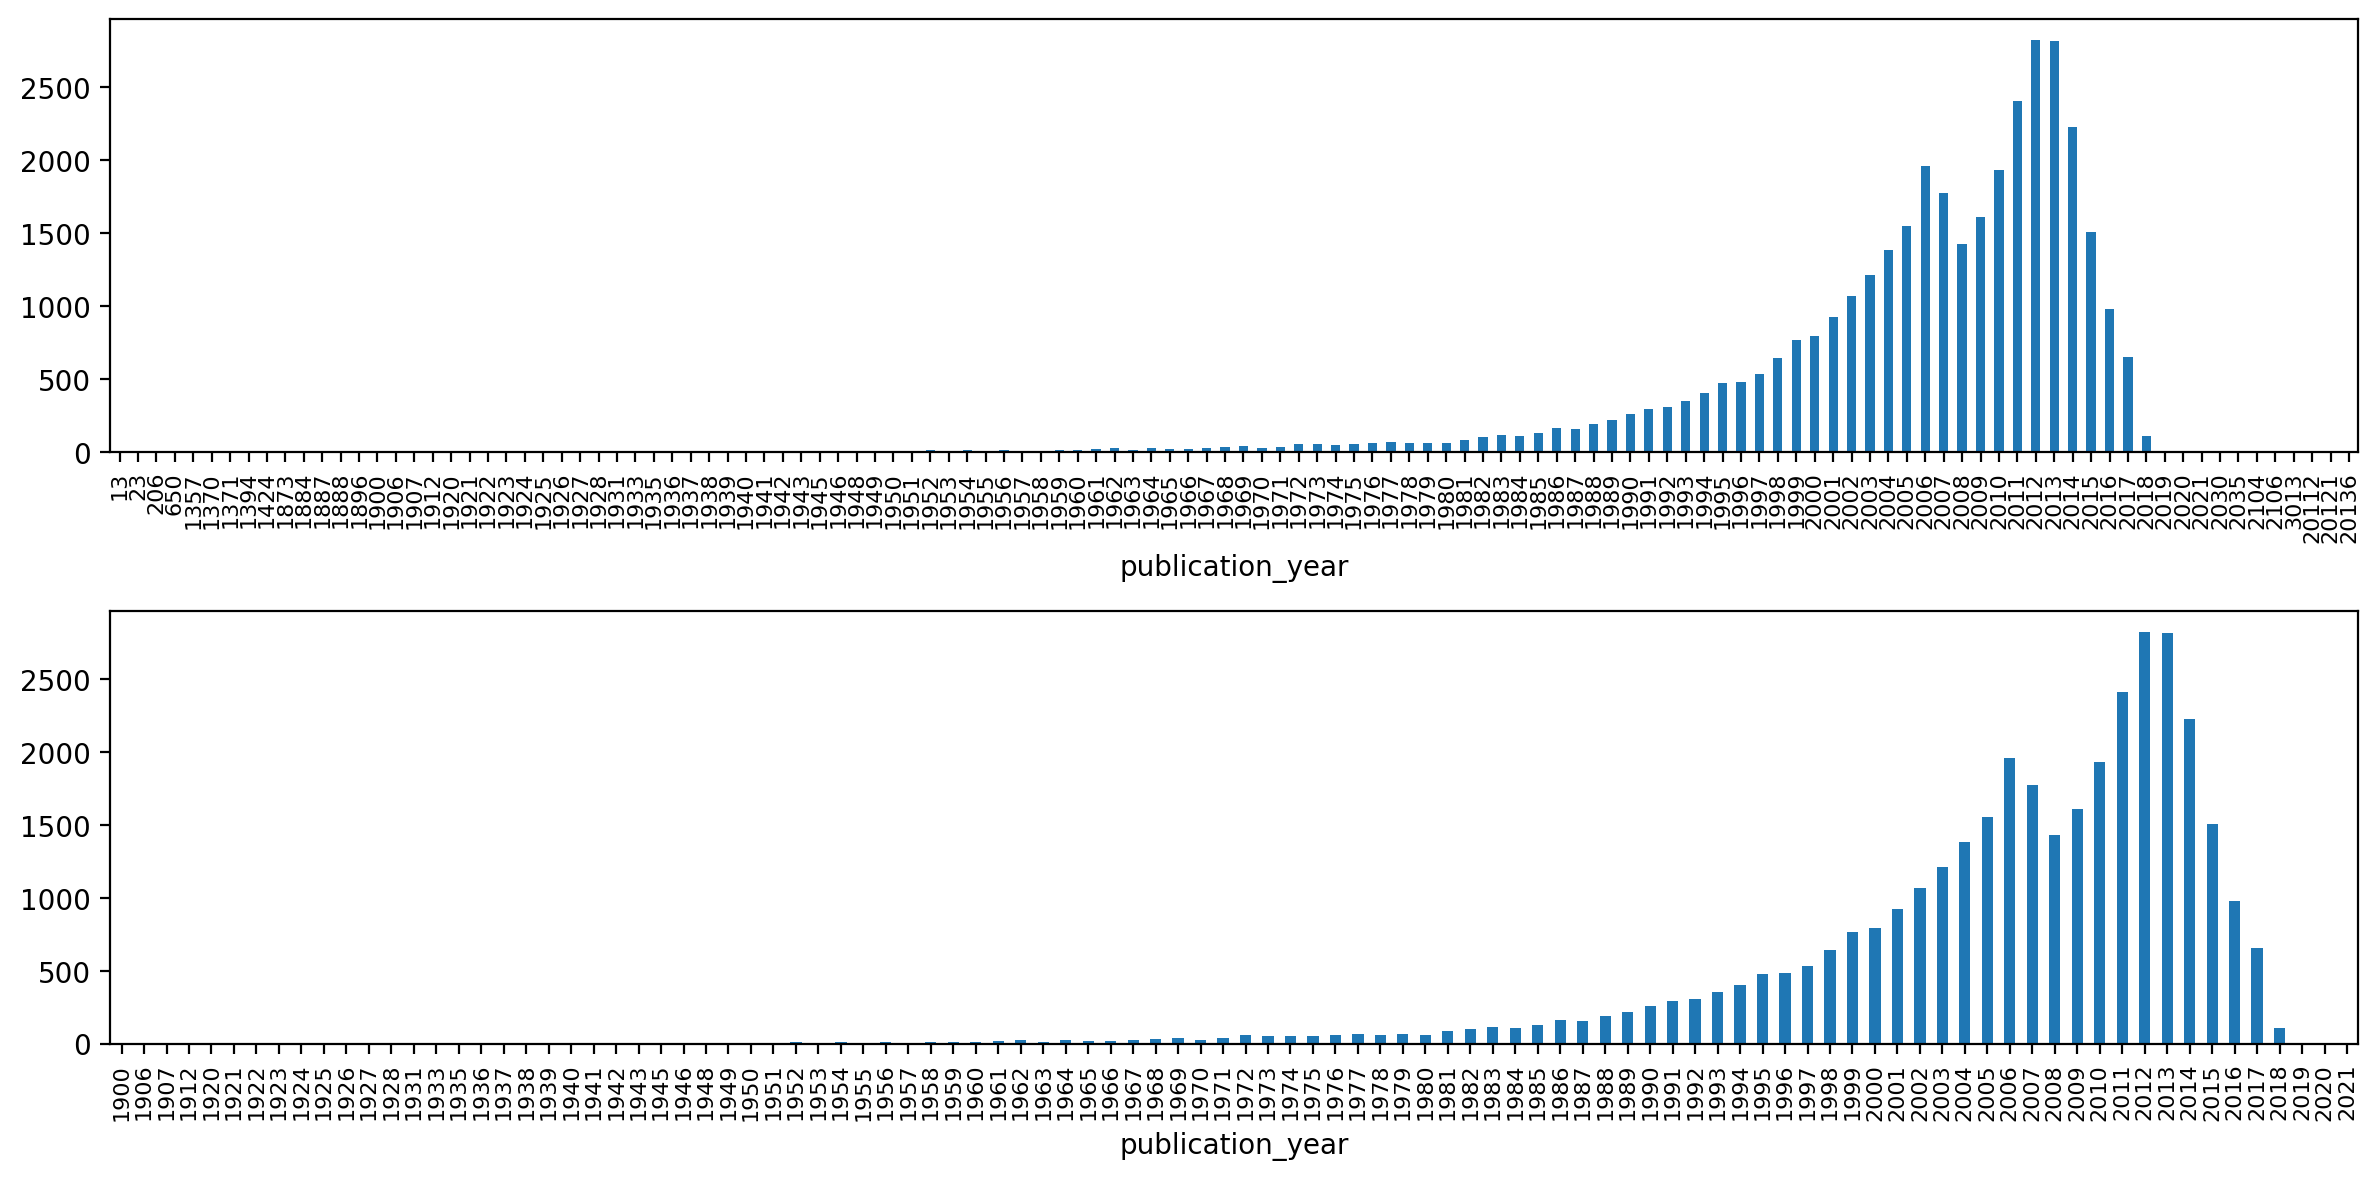

In [11]:
# распределение книг по годам публикации

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
books["publication_year"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.tick_params(axis='x', labelsize=8)

ax = axs[1]
books.query("publication_year >= 1900 and publication_year <= 2025")["publication_year"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.tick_params(axis='x', labelsize=8)

fig.tight_layout()

# События по месяцам

In [12]:
from pandas.tseries.offsets import MonthEnd

interactions["started_at_month"] = pd.to_datetime(interactions["started_at"]).dt.to_period('M').dt.to_timestamp().dt.date

In [13]:
interactions_by_month = interactions.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

In [14]:
interactions_by_month

,started_at_month,events,users
0,2007-01-01,1993,1071
1,2007-02-01,201,135
2,2007-03-01,222,152
3,2007-04-01,201,135
4,2007-05-01,204,138
...,...,...,...
127,2017-08-01,202129,93040
128,2017-09-01,172187,82694
129,2017-10-01,108107,58076
130,2017-11-01,565,475


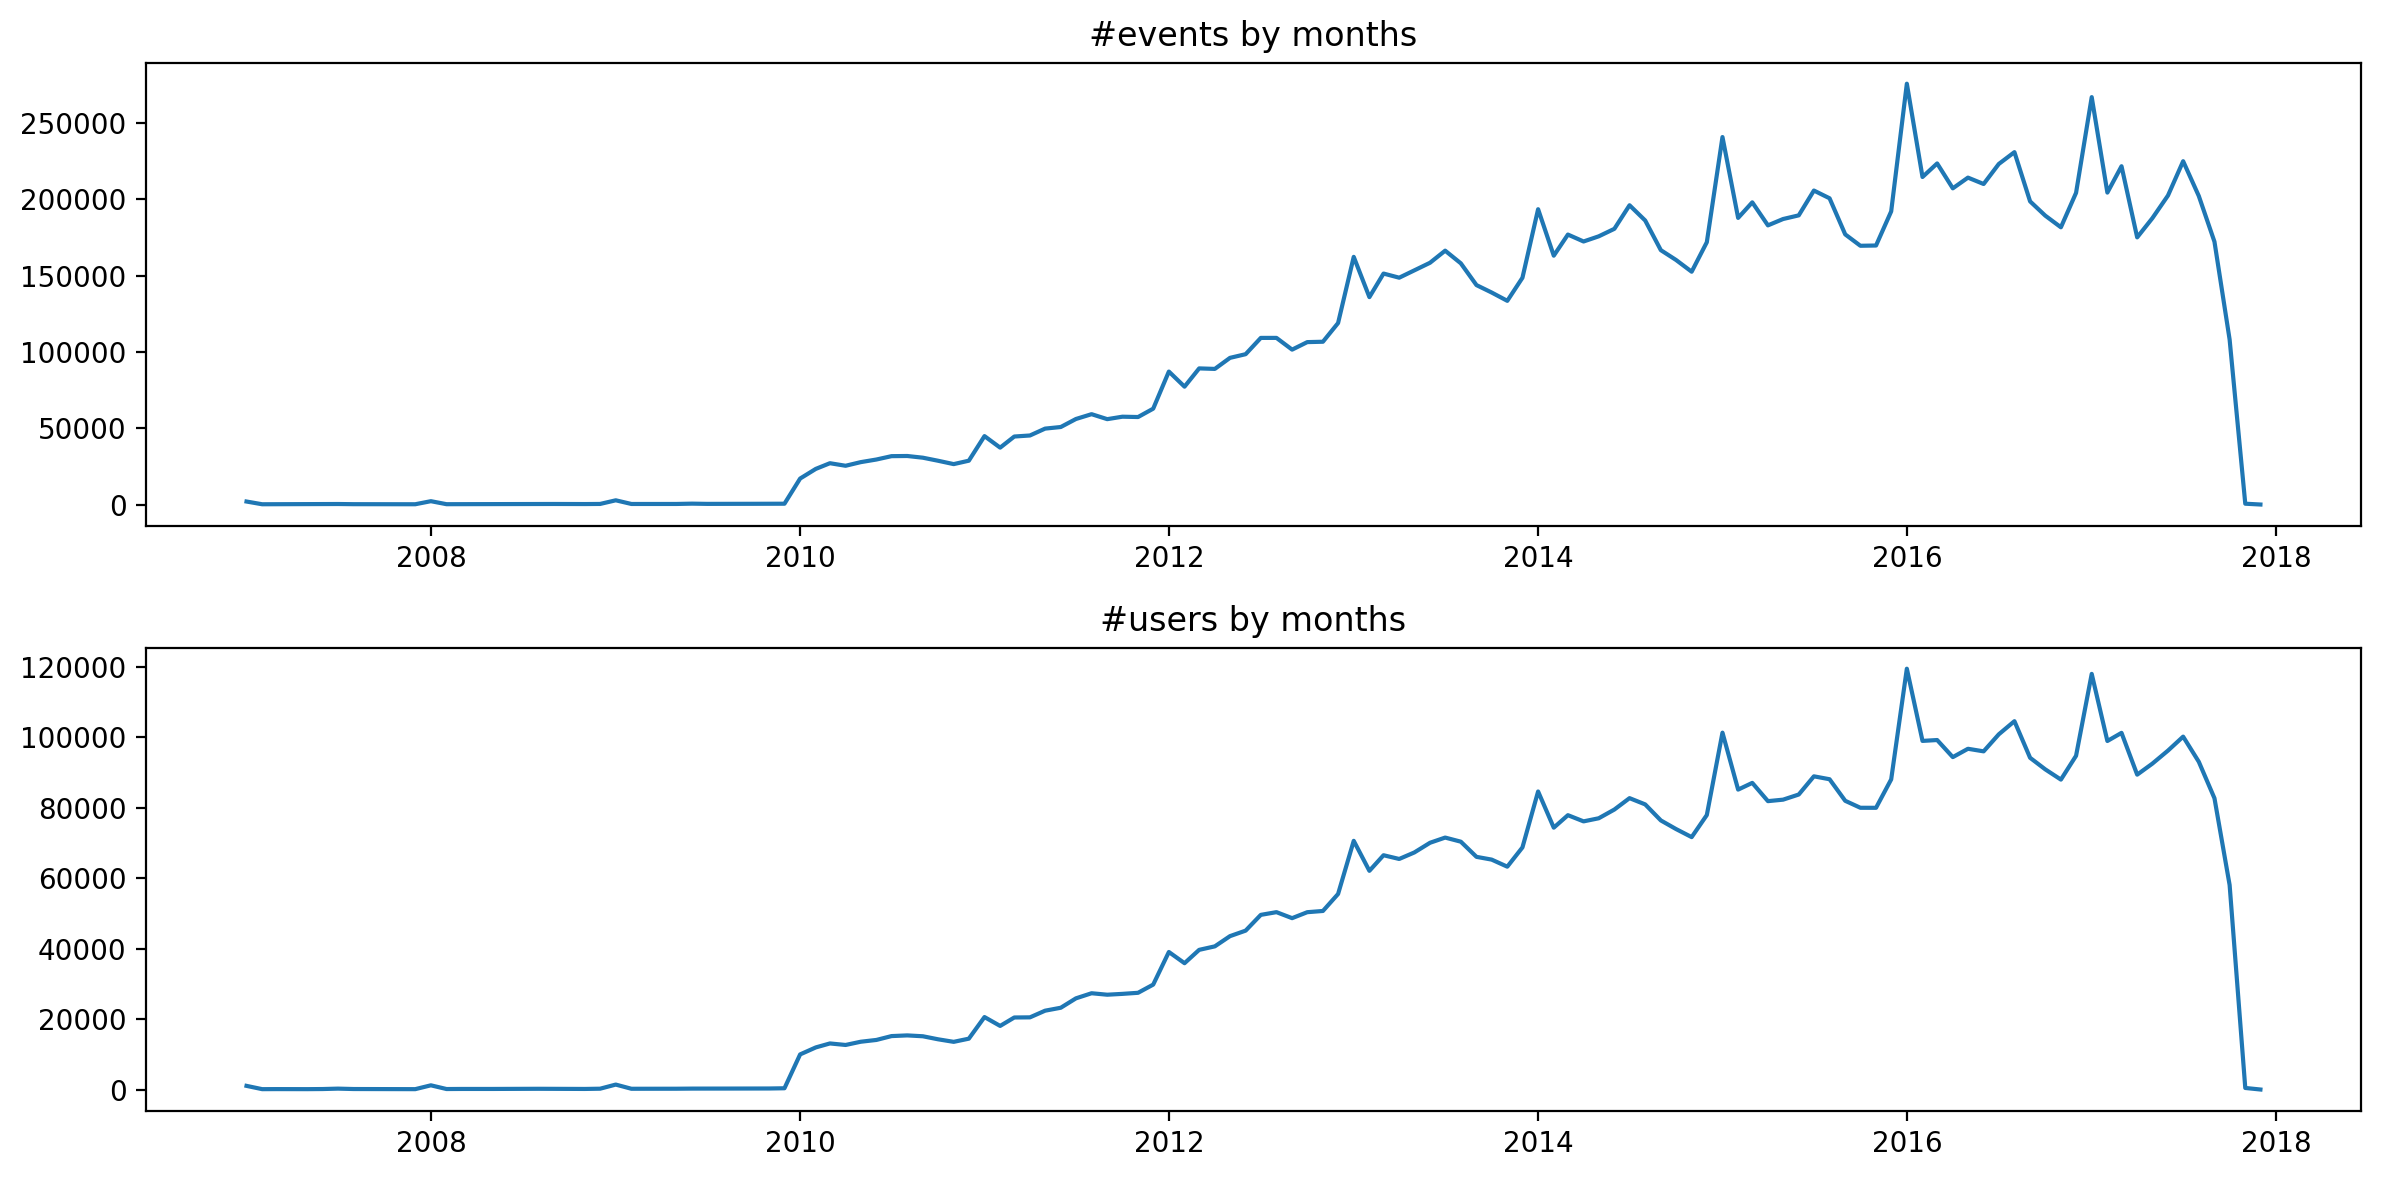

In [15]:
# распределение взаимодействий по годам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(interactions_by_month["started_at_month"], interactions_by_month["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by months")

ax = axs[1]
ax.plot(interactions_by_month["started_at_month"], interactions_by_month["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by months")

fig.tight_layout()

In [16]:
#Оценка количества пользователей
num_users = interactions['user_id'].nunique()
print(f"Количество пользователей: {num_users}")

Количество пользователей: 542657


In [17]:
#Среднее количество прочитанных книг на пользователя
# Фильтруем только те записи, где книга была прочитана (is_read = True)
read_books = interactions[interactions['is_read'] == True]
average_books_per_user = read_books.groupby('user_id').size().mean()
print(f"Среднее количество прочитанных книг на пользователя: {average_books_per_user}")

Среднее количество прочитанных книг на пользователя: 23.7542941489744


In [18]:
# Фильтруем прочитанные книги без рейтинга
unrated_books = read_books[read_books['rating'] == 0]
percentage_unrated = (unrated_books.shape[0] / read_books.shape[0]) * 100
print(f"Доля прочитанных книг без рейтинга: {percentage_unrated}%")

Доля прочитанных книг без рейтинга: 8.158546097051502%


/home/mle-user/sprint_4/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/sprint_4/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/sprint_4/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


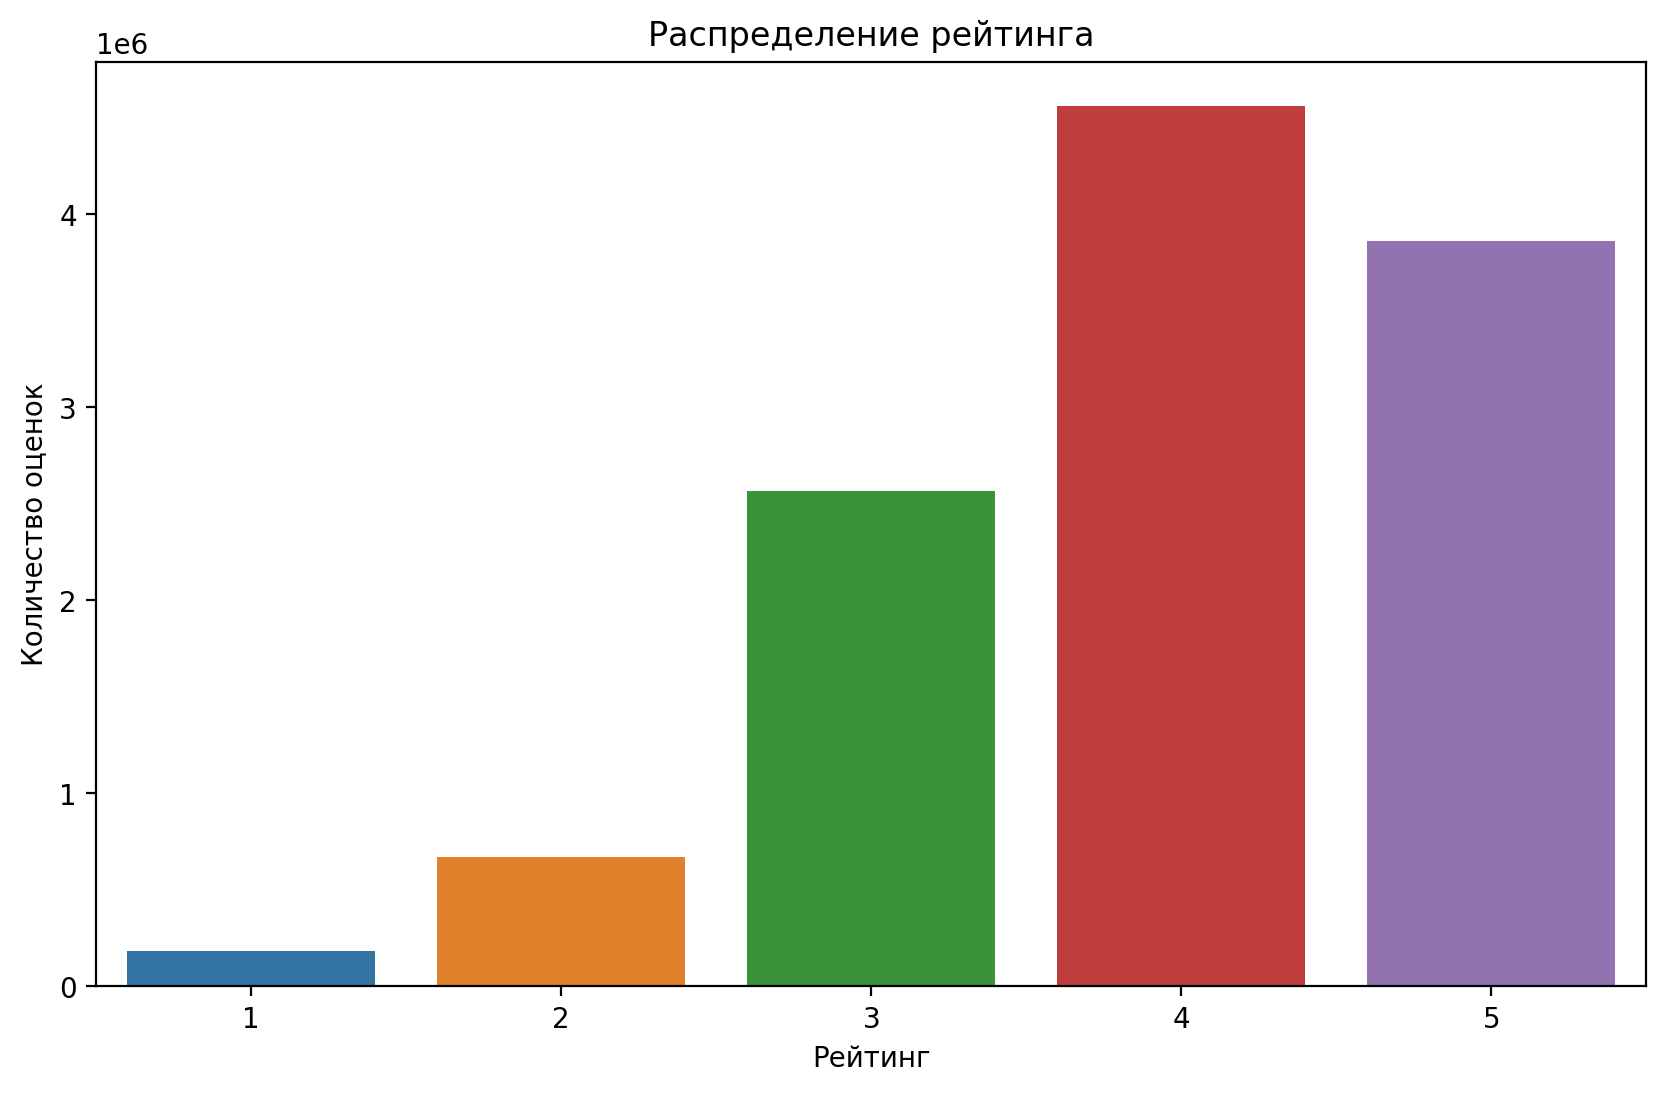

In [19]:
# Распределение рейтинга
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=interactions[interactions['rating'] > 0])
plt.title('Распределение рейтинга')
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок')
plt.show()

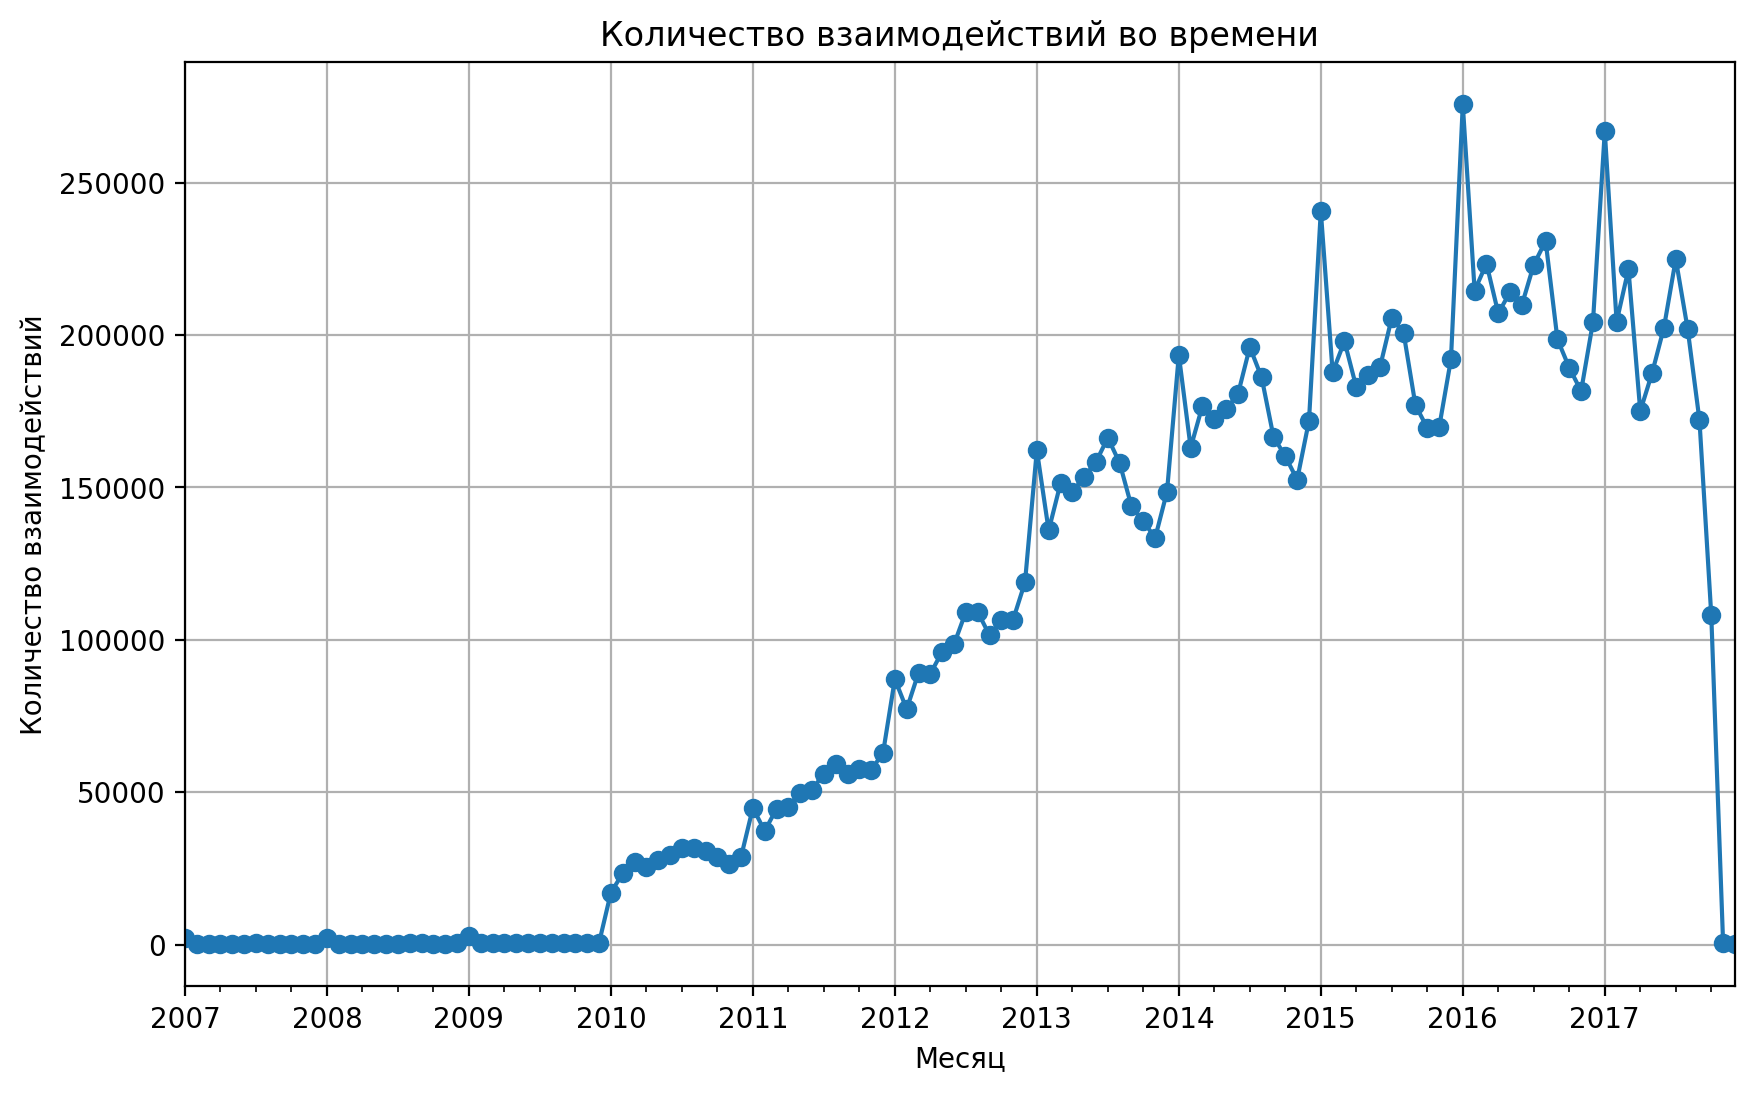

In [20]:
# Преобразуем столбцы дат в формат datetime
interactions['started_at'] = pd.to_datetime(interactions['started_at'])
interactions['read_at'] = pd.to_datetime(interactions['read_at'])

# Группируем данные по месяцу начала чтения
monthly_interactions = interactions.groupby(interactions['started_at'].dt.to_period('M')).size()
monthly_interactions.plot(figsize=(10, 6), marker='o')
plt.title('Количество взаимодействий во времени')
plt.xlabel('Месяц')
plt.ylabel('Количество взаимодействий')
plt.grid(True)
plt.show()

# Преобработка

Примем новые именования:
- books -> items (более обобщённое название)
- interactions -> events (несколько короче, удобнее в коде)

In [21]:
items = books.copy()
events = interactions.copy()

In [22]:
del books
del interactions

In [23]:
# Сохраняем исходное количество событий
initial_event_count = events.shape[0]

In [24]:
# оставим события только до ноября 2017

event_cutoff_date = pd.to_datetime("2017-11-01").date()
events = events.query("started_at < @event_cutoff_date and read_at < @event_cutoff_date").copy()
event_count_after_date_filter = events.shape[0]

# Ваш код здесь

In [25]:
# Переименование столбцов
events.rename(columns={'book_id': 'item_id'}, inplace=True)
items.rename(columns={'book_id': 'item_id'}, inplace=True)

In [26]:
# Переименование DataFrame
items.rename(columns={'books': 'items'}, inplace=True)
events.rename(columns={'interactions': 'events'}, inplace=True)

In [27]:
# Удаление событий без рейтинга
events = events[events['rating'] > 0]
event_count_after_rating_filter = events.shape[0]

In [28]:
# Оставляем только те события, где пользователь прочитал книгу (is_read=True)
events = events[events['is_read'] == True]
event_count_after_read_filter = events.shape[0]

In [29]:
# Фильтрация пользователей с двумя и более прочитанными книгами
user_counts = events['user_id'].value_counts()
filtered_users = user_counts[user_counts >= 2].index
events = events[events['user_id'].isin(filtered_users)]
event_count_after_user_filter = events.shape[0]

In [30]:
# Перекодировка идентификаторов пользователей в числовой формат
user_id_mapping = {user_id: idx for idx, user_id in enumerate(sorted(events['user_id'].unique()), start=1000000)}
events['user_id'] = events['user_id'].map(user_id_mapping)


In [31]:
# Сортировка идентификаторов пользователей и книг
items.sort_values(by='item_id', inplace=True)
events.sort_values(by='user_id', inplace=True)

In [32]:
# Очистка ненужных столбцов, если они есть
events.drop(columns=['started_at', 'read_at', 'is_read'], inplace=True)

In [33]:
# Вывод количества событий до и после каждого шага фильтрации
print(f"Исходное количество событий: {initial_event_count}")
print(f"Количество событий после фильтрации по дате: {event_count_after_date_filter}")
print(f"Количество событий после фильтрации по рейтингу: {event_count_after_rating_filter}")
print(f"Количество событий после фильтрации по прочтению: {event_count_after_read_filter}")
print(f"Количество событий после фильтрации по количеству прочитанных книг пользователей: {event_count_after_user_filter}")

Исходное количество событий: 12890434
Количество событий после фильтрации по дате: 12887523
Количество событий после фильтрации по рейтингу: 11836282
Количество событий после фильтрации по прочтению: 11836282
Количество событий после фильтрации по количеству прочитанных книг пользователей: 11751086


In [34]:
# Вычисление доли оставшихся событий
final_event_count = events.shape[0]
fraction_remaining_events = final_event_count / initial_event_count
print(f"Доля оставшихся событий: {fraction_remaining_events:.2%}")

Доля оставшихся событий: 91.16%


In [35]:
# Определение нового идентификатора для пользователя с изначальным идентификатором 8f50136afeb65c55cec7b3d306c24b03
original_user_id = '8f50136afeb65c55cec7b3d306c24b03'
if original_user_id in user_id_mapping:
    new_user_id = user_id_mapping[original_user_id]
    print(f"Новый идентификатор для пользователя с изначальным идентификатором {original_user_id}: {new_user_id}")
else:
    print(f"Пользователь с изначальным идентификатором {original_user_id} не найден в обработанных данных.")

Новый идентификатор для пользователя с изначальным идентификатором 8f50136afeb65c55cec7b3d306c24b03: 1241243


# Сохранение результатов

In [36]:
items.to_parquet("items.par")

In [37]:
events.to_parquet("events.par")

In [16]:
# Загрузка данных
books = pd.read_parquet('books.parquet')
interactions = pd.read_parquet('interactions.parquet')

In [23]:
# Сохраняем количество событий до фильтрации
initial_event_count = len(interactions)

# Преобразование столбца 'read_at' в тип datetime
interactions['read_at'] = pd.to_datetime(interactions['read_at'])

# Фильтрация данных по дате
interactions = interactions[interactions['read_at'] < datetime(2017, 11, 1)]

# Удаление событий без рейтинга
interactions = interactions[interactions['rating'] > 0]

# Оставляем только события, где is_read=True
interactions = interactions[interactions['is_read']== True]

# Группировка по user_id и подсчет количества прочитанных книг
user_counts = interactions.groupby('user_id').size()

# Оставляем только пользователей с двумя и более прочитанными книгами
active_users = user_counts[user_counts >= 2].index
interactions = interactions[interactions['user_id'].isin(active_users)]

# Сохраняем количество событий после фильтрации
final_event_count = len(interactions)

# Вычисляем долю событий, которые остались
event_fraction = (final_event_count / initial_event_count) * 100

print(f"Доля событий, которые остались после обработки: {event_fraction:.2f}%")

# Переименование данных
books = books.rename(columns={'book_id': 'item_id'})
interactions = interactions.rename(columns={'book_id': 'item_id'})

books = books.rename(columns={'books': 'items'})
interactions = interactions.rename(columns={'interactions': 'events'})

# Создаем словарь для перекодировки user_id
user_id_map = {user_id: idx + 1000000 for idx, user_id in enumerate(interactions['user_id'].unique())}

# Применяем перекодировку к данным
interactions['user_id'] = interactions['user_id'].map(user_id_map)

Доля событий, которые остались после обработки: 100.00%


In [24]:
initial_event_count

11751086

In [25]:
final_event_count

11751086

In [14]:
# Сохранение данных о книгах
items_table = pa.Table.from_pandas(books)
pq.write_table(items_table, 'items.parquet')

# Сохранение данных о взаимодействиях
events_table = pa.Table.from_pandas(interactions)
pq.write_table(events_table, 'events.parquet')